# Clean file with modules

In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
parent_dir1 = os.path.abspath(os.path.join(parent_dir, '..'))
sys.path.append(parent_dir1)

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch import nn
import torch.nn.functional as F
from simspice.data.SproutDataset_NeMg import SproutDataset
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
import numpy as np
import matplotlib.pyplot as plt
from cuml.cluster.hdbscan import HDBSCAN

import matplotlib.pyplot as plt
from lightly.loss import NTXentLoss

import simspice.utils.inverse_mapping_functions as imf
# import simspice.models.Siamese_Architecture as SA
# import simspice.models.Siamese_Architecture_Transformer as SA
import simspice.models.Siamese_Architecture_Resnet as SA
# import simspice.models.SimCLR_Architecture_Resnet as SA
import wandb
#import umap.umap_ as umap
import tqdm
from datetime import datetime

plt.rcParams['image.origin'] = 'lower'

BATCH_SIZE = 128

In [2]:
simspice = "/d0/tvaresano/SimSPICE/"

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
dataset_path = simspice+"spectra_train_NeMg.nc"
dataset = SproutDataset(dataset_path=dataset_path, augmentation_type='single', csv_files=simspice+'L2_names.csv',
                                           log_space=False, normalize_intensity=False, shift_range=(-0.4, 0.4), gain_range=(0.1, 3))

dataloader = DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=True)

## Train model

In [5]:
id = 'resnet50_SimSiam_NeMg_gain01-3'

In [6]:
# model = SA.SimSiam(output_dim=32, backbone_output_dim=64, hidden_layer_dim=64)
# accelerator = "gpu" if torch.cuda.is_available() else "cpu"

# wandb_logger = WandbLogger(project="runs_single_augmentation_NeMg", name=f"fullTrained_outdim64_{id}_{datetime.today().strftime('%Y-%m-%d')}", id=id, log_model=True)

# trainer = pl.Trainer(max_epochs=9, devices=1, accelerator=accelerator, logger=wandb_logger)
# trainer.fit(model=model, train_dataloaders=dataloader)

## If loading from previous checkpoint

In [7]:
# checkpoint = simspice+"notebooks/runs_single_augmentation_NeMg/resnet50_simCLR_005-5/checkpoints/epoch=10-step=169708.ckpt"
# model = SA.SimCLR.load_from_checkpoint(checkpoint, output_dim=32, backbone_output_dim=64, hidden_layer_dim=64)  # Continue epochs

# accelerator = "gpu" if torch.cuda.is_available() else "cpu"
# wandb_logger = WandbLogger(project="runs_single_augmentation_NeMg", name = 'fullTrained_outdim32_resnet50_SimCLR_NeMg_gain005-5_2025-08-20', resume='must', id='02jkyqbh', log_model=True)
# trainer = pl.Trainer(max_epochs=5, devices=1, accelerator=accelerator, logger=wandb_logger)
# trainer.fit(model=model, train_dataloaders=dataloader)

-------------------------------------------------------------------

In [ ]:
dataset_path = simspice+"/spectra_train_NeMg.nc"
dataset_none = SproutDataset(dataset_path=dataset_path, augmentation_type=None, csv_files=simspice+'L2_names.csv',
                                           log_space=False, normalize_intensity=False)
checkpoint = '/d0/tvaresano/SimSPICE/notebooks/runs_single_augmentation_NeMg/resnet50_SimSiam_NeMg_gain01-3/checkpoints/epoch=8-step=138852.ckpt'
model = SA.SimSiam.load_from_checkpoint(
    checkpoint,
    output_dim=32,
    backbone_output_dim=64,
    hidden_layer_dim=64
)

# Move model to device ONCE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Use DataLoader for batching + parallel workers
loader = DataLoader(dataset_none, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

outputs = []
with torch.no_grad():
    for spec in tqdm.tqdm(loader):
        spec = spec.to(device)
        batch_out = model(spec)[0]  # shape: (batch, ...)
        outputs.append(batch_out.cpu())

# Concatenate all batches into one tensor
outputs = torch.cat(outputs, dim=0).numpy()

In [ ]:
outputs.shape

(1974720, 32)

In [ ]:
# checkpoint = "C:\\Users\\tania\Documents\CU Boulder\CU Alpine\models_ckpts\single_epoch=4-step=45750.ckpt"
# dataset_none = SproutDataset(dataset_path=dataset_path, augmentation_type=None)
# outputs = SA.run_model(checkpoint, dataset_none)

In [ ]:
stacked_outputs = np.stack(outputs).squeeze()
np.save(simspice+f'notebooks/jobs/model_outputs/stacked_outputs_single32_full_{id}_fullrun.npy', stacked_outputs)

In [6]:
stacked_outputs = np.load(simspice+f'notebooks/jobs/model_outputs/stacked_outputs_single32_full_{id}_fullrun.npy')

## Clustering

In [ ]:
# for x in [10, 20, 30]:
# for x in [30, 40, 50]:
#     # for y in tqdm.tqdm([5, 10, 15]):
#     for y in tqdm.tqdm([15, 30, 50]):
x,y = 100,100
clusterer = HDBSCAN(min_cluster_size=x, min_samples=y, metric='euclidean') # <=> cosine?

clusterer.fit(stacked_outputs)
labels = clusterer.labels_
np.save(simspice+f'notebooks/jobs/clustering/Fulltrained_single32_{id}_minclus{x}_minsamp{y}__all.npy', labels)

In [ ]:
for x in [10, 20, 30]:
    for y in tqdm.tqdm([5, 10, 15]):
        clusterer = HDBSCAN(min_cluster_size=x, min_samples=y, metric='euclidean') # <=> cosine?
        clusterer.fit(stacked_outputs)
        labels = clusterer.labels_
        np.save(simspice+f'notebooks/jobs/clustering/Fulltrained_single32_{id}_minclus{x}_minsamp{y}__all.npy', labels)

In [ ]:
c=0
dataset_path = simspice+"spectra_Feb2023.nc"
plt.figure(figsize=(15,12), tight_layout=True)
for x in [10, 20, 30]:
    for y in [5, 10, 15]:
        c+=1
        plt.subplot(4,3,c)
        labels = np.load(simspice+f'notebooks/jobs/clustering/Fulltrained_single32_{id}_minclus{x}_minsamp{y}__all.npy')
        imf.map_clusters(labels, dataset_path=dataset_path, selected_clusters=None)
        plt.title(f"min_cluster = {x}\nmin_samples = {y}")
plt.suptitle(f'Feb23_double32_full_trained_{id}')

# UMAP

In [12]:
from cuml import UMAP
from matplotlib.colors import Normalize

In [13]:
stacked_outputs = np.load(simspice+f'notebooks/jobs/model_outputs/stacked_outputs_single32_full_{id}.npy')

In [14]:
reducer = UMAP(n_neighbors=30, min_dist=0.01, n_components=2, random_state=42)
projected_data = reducer.fit_transform(stacked_outputs)

[2025-08-25 14:50:09.461] [CUML] [info] build_algo set to brute_force_knn because random_state is given


In [15]:
np.save(simspice+f'notebooks/jobs/umap/umap_{id}_nneigh30.npy', projected_data)

In [ ]:
# reducer = UMAP(n_neighbors=30, min_dist=0.01, n_components=3, random_state=42)
# projected_data = reducer.fit_transform(stacked_outputs)

In [ ]:
# np.save(simspice+f'notebooks/jobs/umap/umap_{id}_nneigh30_3D.npy', projected_data)

## Plot 3D

In [ ]:
c=0
plt.figure(figsize=(15,12), tight_layout=True)
for x in [10, 20, 30]:
    for y in [5, 10, 15]:
        c+=1
        plt.subplot(4,3,c)
        labels = np.load(simspice+f'notebooks/jobs/clustering/Fulltrained_single32_{id}_minclus{x}_minsamp{y}.npy')
        target_clusters = np.unique(labels)[1:]  # List of cluster labels to plot
        
        selected_points = projected_data[np.isin(labels, target_clusters)]
        selected_labels = labels[np.isin(labels, target_clusters)]
        norm = Normalize(vmin=labels.min(), vmax=labels.max())

        plt.scatter(selected_points[:, 0], selected_points[:, 1], c=selected_labels, cmap='tab20', norm=norm, s=3)
        plt.title(f"n_neighbors=30, min_dist=0.01\nmin_cluster_size={x}, min_samples={y}")
        plt.colorbar()
plt.show()

## Plot 2D

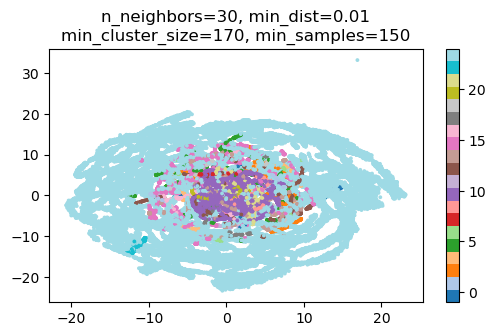

In [18]:
c=0
plt.figure(figsize=(15,12), tight_layout=True)
# for x in [10, 20, 30]:
#     for y in [5, 10, 15]:
c+=1
plt.subplot(4,3,c)
labels = np.load(simspice+f'notebooks/jobs/clustering/Fulltrained_single32_{id}_minclus{x}_minsamp{y}.npy')
target_clusters = np.unique(labels)[1:]  # List of cluster labels to plot

selected_points = projected_data[np.isin(labels, target_clusters)]
selected_labels = labels[np.isin(labels, target_clusters)]
norm = Normalize(vmin=labels.min(), vmax=labels.max())

plt.scatter(selected_points[:, 0], selected_points[:, 1], c=selected_labels, cmap='tab20', norm=norm, s=3)
plt.title(f"n_neighbors=30, min_dist=0.01\nmin_cluster_size={x}, min_samples={y}")
plt.colorbar()
plt.show()

In [27]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.01, n_components=2, random_state=42)
projected_data = reducer.fit_transform(stacked_outputs)
np.save(simspice+f'notebooks/jobs/umap/umap_{id}_nneigh10.npy', projected_data)

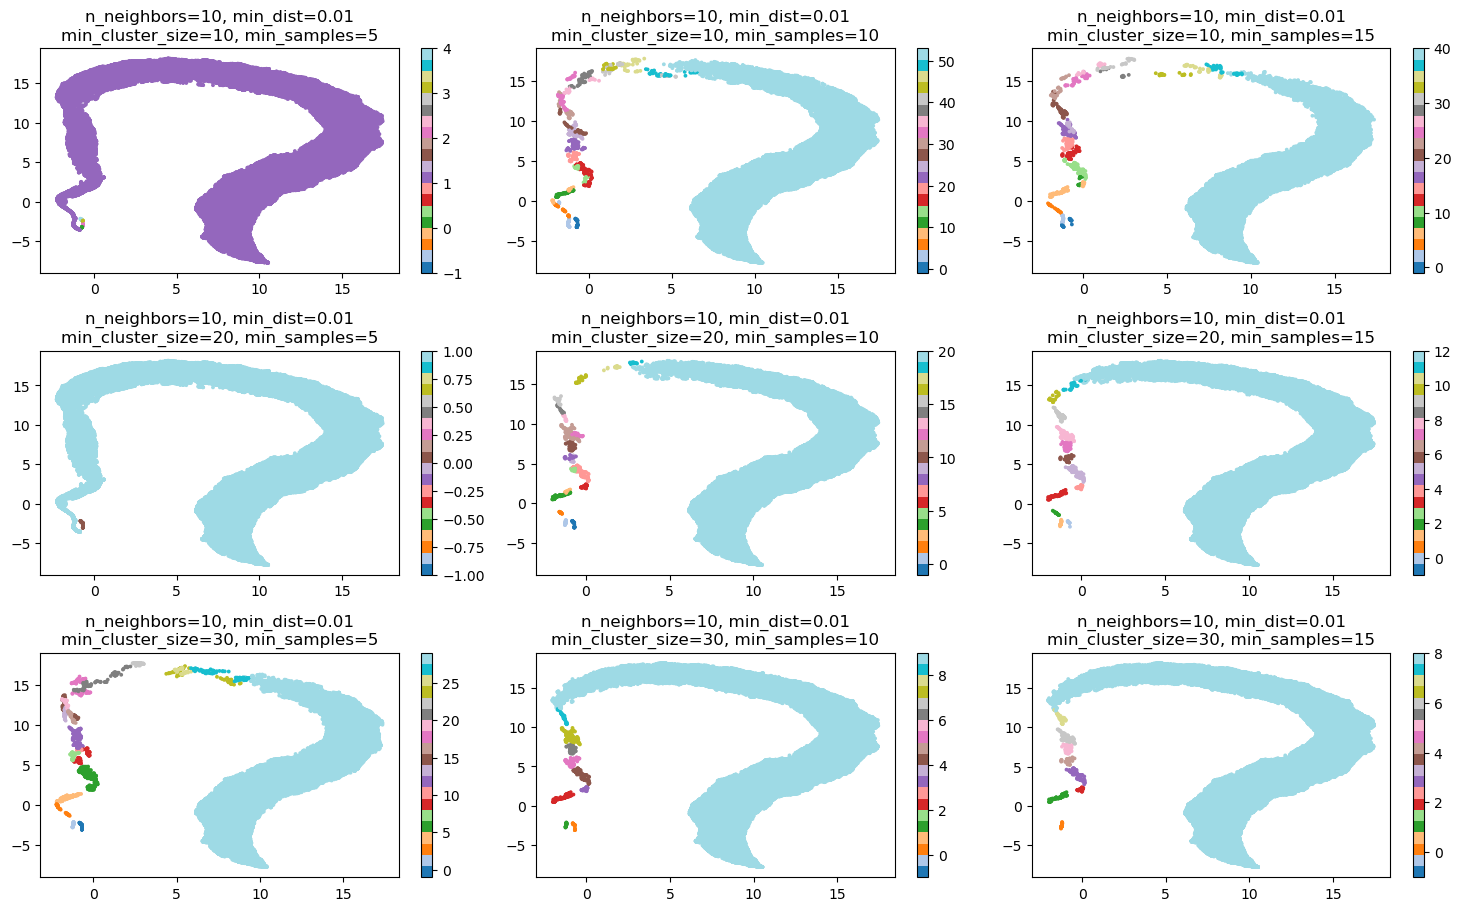

In [28]:
c=0
plt.figure(figsize=(15,12), tight_layout=True)
for x in [10, 20, 30]:
    for y in [5, 10, 15]:
        c+=1
        plt.subplot(4,3,c)
        labels = np.load(simspice+f'notebooks/jobs/clustering/Fulltrained_single64_{id}_minclus{x}_minsamp{y}.npy')
        target_clusters = np.unique(labels)[1:]  # List of cluster labels to plot
        
        selected_points = projected_data[np.isin(labels, target_clusters)]
        selected_labels = labels[np.isin(labels, target_clusters)]
        norm = Normalize(vmin=labels.min(), vmax=labels.max())

        plt.scatter(selected_points[:, 0], selected_points[:, 1], c=selected_labels, cmap='tab20', norm=norm, s=3)
        plt.title(f"n_neighbors=10, min_dist=0.01\nmin_cluster_size={x}, min_samples={y}")
        plt.colorbar()
plt.show()